<a href="https://colab.research.google.com/github/engrvitalis/NAU/blob/main/ANN_Welding_Analysis4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uploading the needed *files*

In [6]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Analyzing welding data by welding types

In [7]:
df2 = pd.read_csv('welding_data_by_welding_types.csv')
df2 = pd.get_dummies(df2).drop('welding_type_SAW', axis=1)
df2 = df2[['current',	'voltage',	'welding_speed',	'plate_thickness',
           'welding_type_GMAW',	'welding_type_GTAW',	'welding_type_SMAW',
           'heat_input',	'tensile_strength',	'flexural_strength',	'hardness_value']]
df2.head()

,current,voltage,welding_speed,plate_thickness,welding_type_GMAW,welding_type_GTAW,welding_type_SMAW,heat_input,tensile_strength,flexural_strength,hardness_value
0,160,32,120,6,0,1,0,1536,432.6,236.2,102.5
1,130,32,90,8,0,0,1,2218,332.8,270.2,96.4
2,100,28,120,8,0,1,0,840,382.4,360.8,86.4
3,160,28,90,10,0,1,0,1792,422.8,230.0,105.0
4,100,28,120,8,0,0,0,1400,385.5,276.5,128.4


Exploratory data analysis

	Current vs Response values


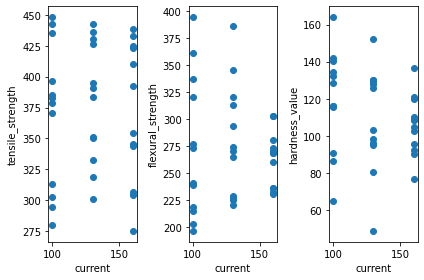



	Voltage vs Response values


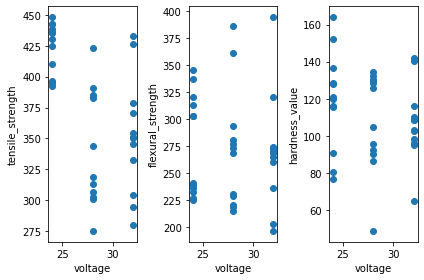



	Welding_speed vs Response values


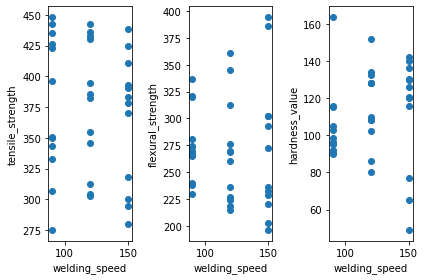



	Plate_thickness vs Response values


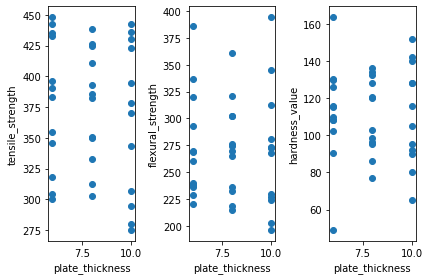

In [8]:
pos = 1
for i in range(4):
  print(f'\t{df2.columns[i].capitalize()} vs Response values')
  plt.figure()
  for j in range(8, 11):
    plt.subplot(1, 3, pos)
    plt.scatter(df2.iloc[:, i], df2.iloc[:, j])
    plt.ylabel(df2.columns[j])
    plt.xlabel(df2.columns[i])
    pos += 1
  plt.tight_layout()
  plt.show()
  print('\n')
  pos = 1

Generate the necessary variables for modeling

In [9]:
X1 = df2.iloc[:, :7]
X = X1.to_numpy()
y1 = df2.iloc[:, -4:]
y = y1.to_numpy()

Predicting individual response separately to optimize prediction

In [18]:
for h in range(5, 35, 5):
  print(f'For {h} nodes')
  print('______________________')
  for i in range(y.shape[1]):
    cols = y[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X, cols,random_state=1, test_size=0.2)

    sc_X = StandardScaler()
    X_trainscaled=sc_X.fit_transform(X_train)
    X_testscaled=sc_X.transform(X_test)

    reg = MLPRegressor(hidden_layer_sizes=(h,h,h),activation="relu" ,random_state=1, max_iter=1000000).fit(X_trainscaled, y_train)

    y_pred=reg.predict(X_testscaled)
    print(f'R^2 for Response variable, {y1.columns[i].capitalize()}: {(r2_score(y_pred, y_test))}')
    print(f'Expected value: {y_test}')
    print(f'Predicted value: {y_pred}')

For 5 nodes
______________________
R^2 for Response variable, Heat_input: 0.8661193737423302
Expected value: [1120. 1280.  960. 1792. 1024. 2048.  936.  768.]
Predicted value: [1026.4897184  1407.27380527 1207.82468634 1847.50171476 1247.75710251
 2177.30674504  944.80145158  944.20455614]
R^2 for Response variable, Tensile_strength: -0.38712887190254675
Expected value: [312.8 442.6 396.5 422.8 280.2 304.2 394.6 378.5]
Predicted value: [341.09719031 341.92126559 450.1765176  342.85270489 350.28960194
 219.01399701 337.17652011 337.90251408]
R^2 for Response variable, Flexural_strength: 0.18911148517638776
Expected value: [218.4 238.4 336.8 230.  196.  260.  345.  394.4]
Predicted value: [203.50861914 196.99204955 422.71930132 317.95004827 253.30015653
 234.99845798 305.27597834 301.69155971]
R^2 for Response variable, Hardness_value: 0.012210338877166271
Expected value: [132.5 116.2  90.6 105.  142.2 110.   80.5  65. ]
Predicted value: [121.67279322 158.33851663 113.17549332  85.691807